In [1]:
import os

import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 200
plt.rcParams['text.usetex'] = True

from scipy.interpolate import interp1d as interp1d
import scipy.integrate as integrate
import scipy.optimize as opt

from migdalcalc import migdalcalc as mc
from migdalcalc.migdal import quench
from migdalcalc.migdal import ionization as ion
from migdalcalc.migdal import kinematics as kin
from migdalcalc.migdal import dm 

In [2]:
Xe_migdal = mc.migdalcalc(target="Xe-131")

In [3]:
print(integrate.quad(lambda v: v*dm.dm_maxwell_dist(v), 0, np.inf))

(329.5395485772524, 1.772617087280481e-06)


In [4]:
def d3R_dEnr_dDeltaE_dV(rho_dm, m_dm, sigma_n, A):
    d2R = dm.dR0_dEnr_dv(rho_dm, m_dm, sigma_n, A)
    
    def d3R(Enr, DeltaE):
        return d2R(Enr, dm.vmin(Enr, DeltaE, m_dm, A))*kin.q_e2(Enr, A)*Xe_migdal.mig.dP_dDeltaE(DeltaE, method='ibe')

    return d3R

In [5]:
def d3R_dEnr_dEdet_dV(rho_dm, m_dm, sigma_n, A):
    Q = 0.15
    DeltaE = lambda Enr, Edet: Edet - Q*Enr
    
    d3R = d3R_dEnr_dDeltaE_dV(rho_dm, m_dm, sigma_n, A)
    
    return lambda Enr, Edet: d3R(Enr, DeltaE(Enr, Edet))

In [6]:
def dR_dEdet(rho_dm, m_dm, sigma_n, A, unit=1):
    d3R = d3R_dEnr_dEdet_dV(rho_dm, m_dm, sigma_n, A)
    vesc = 533.0
    c = 3e5
    Edet_range = np.geomspace(1, 1e5, 100)
    dR_out = []
    
    m_n = 0.939*1e9
    mu_N = kin.mu(A*m_n, m_dm)
    
    Enr_max = (1/2)*(mu_N**2)*(1/m_dm)*(vesc/c)**2
    
    for Edet in Edet_range:
        Emax = min(Enr_max, Edet/0.15)
        Emin = max(1e-6, (Edet - 1.2e3)/0.15)
        Enr_range = np.geomspace(Emin, Emax, 100)
#         plt.plot(Enr_range, d3R(Enr_range, Edet))
#         xmin, xmax, ymin, ymax = plt.axis()
#         plt.vlines(Emin, ymin, ymax)
#         plt.vlines(Emax, ymin, ymax)
#         plt.xscale('log')
#         plt.yscale('log')
#         plt.show()
        dR = integrate.quad(lambda Enr: d3R(Enr, Edet), 1e-3, Edet/0.15)[0]
        print(Edet, dR, Emin, Emax)
        
        dR_out.append(unit*dR)
        
    return interp1d(Edet_range, dR_out, bounds_error=False, fill_value = 0, kind='linear')
        
        

In [7]:
# rho_dm = 0.3*1e9
# m_dm = 100*1e9
# sigma_n = 1e-46
# A = 131
# d3R = d3R_dEnr_dEdet_dV(rho_dm, m_dm, sigma_n, A)

# Enr_range = np.geomspace(1e-6, 280, 50)
# plt.plot(d3R(Enr_range, 30))
# plt.plot(d3R(Enr_range, 40))
# plt.yscale('log')
# plt.xscale('log')
# plt.show()

# print(integrate.quad(lambda x: d3R(x,33.9322177189533), 1e-6, 226.1, limit=200))
# print(integrate.quad(lambda x: d3R(x,42.91934260128778), 1e-6, 286.13, limit=200))



In [8]:
A = Xe_migdal.A
N_per_kg = (6.02e26/A)
seconds_to_days = 60*60*24 #seconds to days

xsec_to_inv_kg_days = N_per_kg*seconds_to_days*1e-3

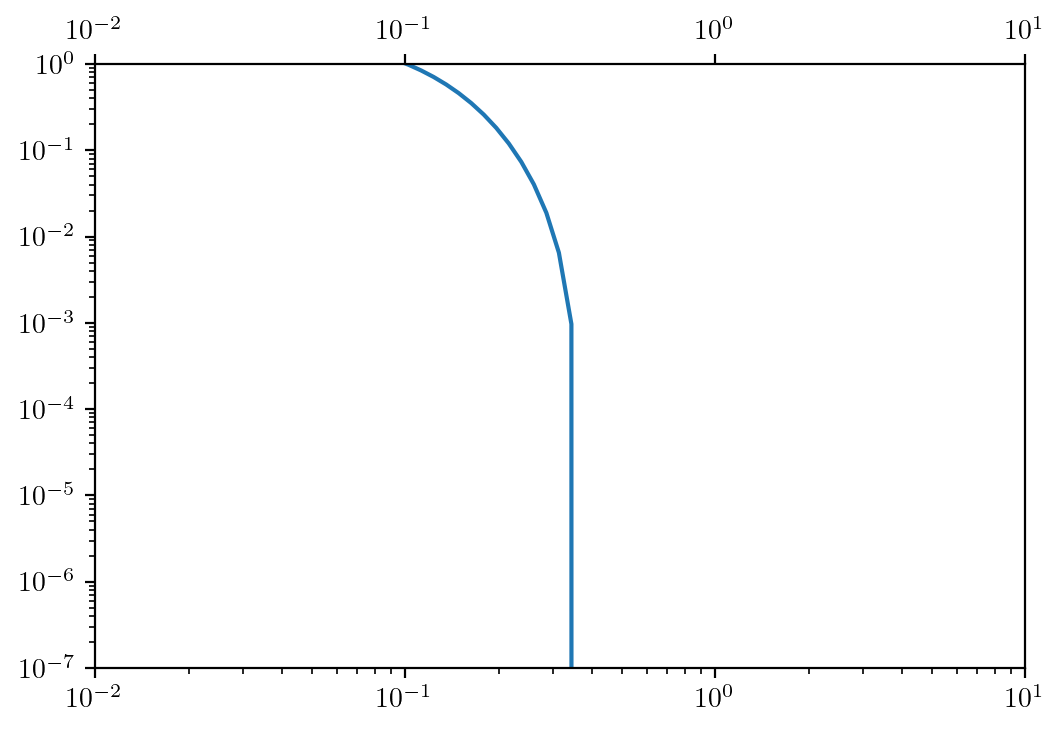

In [9]:
mdm=5*1e9
dR_el = dm.dR0_dEnr_dv(0.3*1e9, mdm, 1e-42, 131)
Edet_range = np.geomspace(1e-2, 1e2, 100)
dR_dEdet_elastic = []

for Edet in Edet_range:
    Edet_eV = 1e3*Edet
    #dR_dEdet_elastic.append(2*np.pi*3e5*integrate.quad(lambda v: dR_el(Edet_eV/0.15, v), dm.vmin(Edet_eV/0.15, 0, mdm, 131), np.inf)[0])
    dR_dEdet_elastic.append(3e5*dR_el(Edet_eV/0.15, dm.vmin(Edet_eV/0.15, 0, mdm, 131)))
plt.plot(Edet_range, dR_dEdet_elastic)
plt.xscale('log')
plt.yscale('log')
plt.tick_params(labeltop=True, top=True)
plt.xlim(1e-2, 1e1)
plt.ylim(1e-7, 1e0)
plt.show()

In [10]:
dR = dR_dEdet(0.3*1e9, 2*1e9, 1e-40, 131)

1.0 0.0 1e-06 6.666666666666667
1.1233240329780274 0.0 1e-06 7.488826886520183
1.2618568830660204 0.0 1e-06 8.412379220440137
1.4174741629268053 0.0 1e-06 9.44982775284537
1.5922827933410924 0.0 1e-06 10.61521862227395
1.788649529057435 0.0 1e-06 11.924330193716234
2.0092330025650473 0.0 1e-06 13.394886683766982
2.25701971963392 0.0 1e-06 15.046798130892801
2.535364493970112 0.0 1e-06 16.902429959800745
2.8480358684358014 0.0 1e-06 18.98690578957201
3.1992671377973836 0.0 1e-06 21.328447585315892
3.5938136638046276 0.0 1e-06 23.95875775869752
4.0370172585965545 0.0 1e-06 26.913448390643698
4.534878508128582 0.0 1e-06 30.23252338752388
5.094138014816379 0.0 1e-06 33.960920098775865
5.722367659350217 0.0 1e-06 38.14911772900145
6.42807311728432 0.0 1e-06 42.85382078189547
7.220809018385464 0.0 1e-06 48.13872678923643
8.11130830789687 0.0 1e-06 54.07538871931247
9.111627561154892 0.0 1e-06 60.744183741032614
10.235310218990262 4.777110191027232e-09 1e-06 68.23540145993509
11.4975699539773

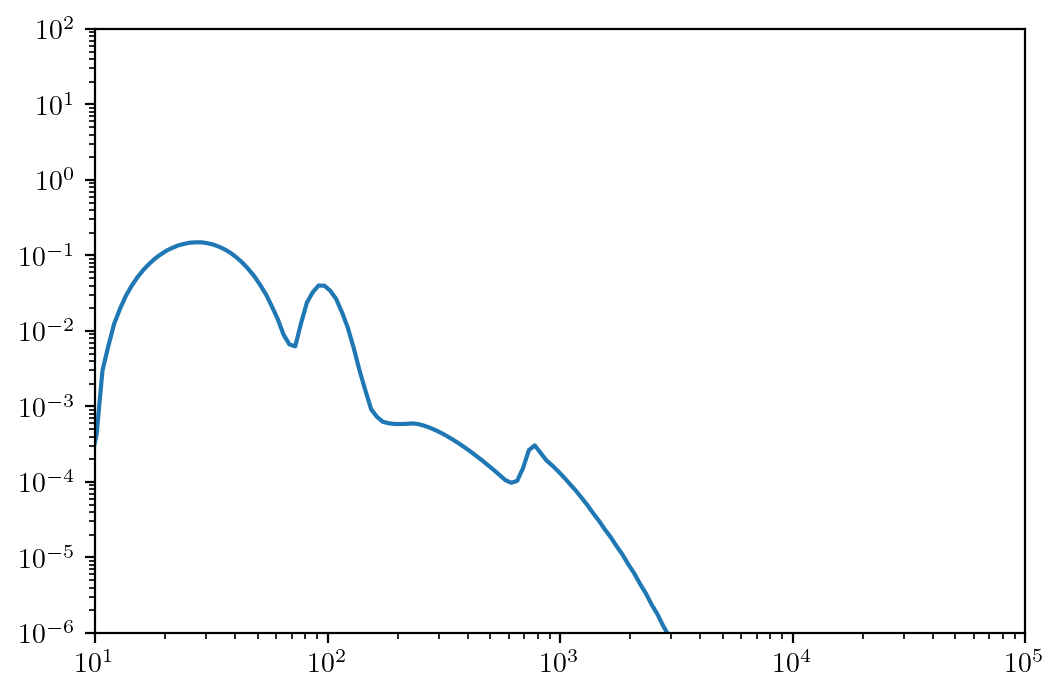

In [11]:
Edet_range = np.geomspace(1, 1e5, 200)

plt.plot(Edet_range, 1e5*dR(Edet_range))
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-6, 1e2)
plt.xlim(10, 1e5)
plt.show()
